<a href="https://colab.research.google.com/github/DantonCoote/My_RRC_HUB/blob/DeepLearning/Assign3_Group9_NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 for Neural Networks and Deep Learning

## Step 1.1, Loading the Data

In this assignment we are using a public built in dataset from the Tensorflow/Keras library.<br>
This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories

In [1]:
import keras as ks


(features_train, label_train), (features_test, label_test) = ks.datasets.cifar10.load_data()

Well things have been loaded. Time to explore our dataset. <br>
There seems to be multiple ways to load this data, one of which doesn't load the set but instead generates it.

## Step 1.2, Data Exploration

In [2]:
# combining data into single dataframes for analysis
import numpy as np

labels_t = np.concatenate([label_train, label_test])
print(labels_t.shape)
len(labels_t)

(60000, 1)


60000

In [3]:
import pandas as pd
df_labels = pd.DataFrame(labels_t, columns=['Label'])

#counting our unique values and sorting them
df_labels_counts = df_labels['Label'].value_counts().sort_index()
df_labels_counts.info()

<class 'pandas.core.series.Series'>
Index: 10 entries, 0 to 9
Series name: count
Non-Null Count  Dtype
--------------  -----
10 non-null     int64
dtypes: int64(1)
memory usage: 90.0 bytes


<Axes: xlabel='Label'>

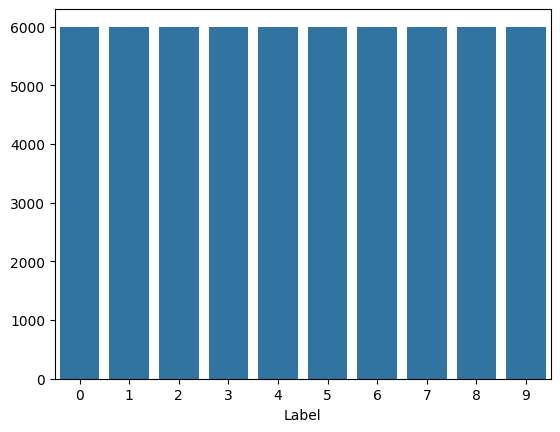

In [4]:
import seaborn as sb
sb.barplot(x=df_labels_counts.index, y=df_labels_counts.values)

Well we see a very even split of our data!

In [5]:
# Splitting our test data into validation and test sets
from sklearn.model_selection import train_test_split as tts

# actually testing our data
test_data, test_labels, val_data, val_labels = tts(features_test, label_test, train_size= 0.5)
print(len(val_data))
print(len(test_data))
print(len(val_labels))

5000
5000
5000


Simply splitting our test data evenly between a test and validation set<br><br>
Now I am going to attempt something a bit more extreme as I can build in data augmentation layers into my Neural Network. This is not something we have covered in class but it seems the newer Keras and Tensorflow libraries are more robust and allow for better information flow!


In [6]:
# Gathering our data to combine it into Tensorflow dataset variables
import tensorflow as tf

training = tf.data.Dataset.from_tensor_slices((features_train, label_train)).batch(64)
testing = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(64)
validation = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(64)

## Step 2.1, My Original Model

In [7]:
# Lets build our model's preprocessing layers first
from keras import Sequential # What our model will be built from

# this we are resizing all images to 32 by 32, and scaling the pixels down by
# a factor of 255
resize_and_rescale = tf.keras.Sequential([
  ks.layers.Resizing(32,32),
  ks.layers.Rescaling(1./255)
])

In [8]:
# here we add some layers to augment our data, mainly by adding
# variation and noise
data_augmentation = tf.keras.Sequential([
  ks.layers.RandomFlip("horizontal_and_vertical"),# Flips sections of image
  ks.layers.RandomRotation(0.2)# rotates pixels within a range randomly
])# the last layer should shift images randomly, adding blank spaces

Do they work? I think so, we didn't get errors so that makes life easier. I am still figuring out all this new methodology at this time

In [10]:
# Applies all our preprocessing to a single image at once
def preprocess(image, label):
  """Applies preprocessing to a single image."""
  image = resize_and_rescale(image)
  image = data_augmentation(image)
  return image, label

In [24]:
training = training.map(preprocess)
validation = validation.map(preprocess)
testing = testing.map(preprocess)

ValueError: in user code:

    File "<ipython-input-10-ae1440ed9631>", line 4, in preprocess  *
        image = resize_and_rescale(image)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 244, in _adjust_input_rank
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(None, 1), dtype=float32). Expected shape (None, 32, 32, 3), but input has incompatible shape (None, 1)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(None, 1), dtype=uint8)
      • training=None
      • mask=None


In [20]:
# Here we begin to build the actual Neural Network itself
my_model = Sequential([
    # adding our preprocessing layers
    resize_and_rescale,
    data_augmentation,

    # adding our first major layers
    ks.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    # this layer puts everything into a 2D layer, combining it as a dot product
    # of 32 (the filter)
    ks.layers.MaxPooling2D((2,2)),
    # This layer compounds our data, reducing our features while preserving depth
    # making it more efficient and robust.

    # Our second feature extraction layer
    ks.layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
    ks.layers.MaxPooling2D((2,2)),

    # Flatten the output from the convolutional layers
    # before connecting to the dense layers
    ks.layers.Flatten(),

    # our interconnected layers that do the actual learning and decision making
    ks.layers.Dense(128, activation='relu'),
    ks.layers.Dense(64, activation='relu'),
    ks.layers.Dense(10, activation='softmax')
])

In [21]:
my_model.compile(optimizer='lion',
              loss=ks.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
my_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = my_model.fit(training, validation_data=validation, epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0985 - loss: 2.3031

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_3_1/Cast:0", shape=(None, 1), dtype=float32). Expected shape (None, 32, 32, 3), but input has incompatible shape (None, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1), dtype=uint8)
  • training=False
  • mask=None